### Giới thiệu
- Sử dụng gia tốc trọng trường để nhận diện hành động của con người
- Sẽ có một điểm để phát hiện

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()
# Chọn file kaggle.json tải về ở bước 2 để tải lên

!mkdir '/root/.kaggle'
!cp kaggle.json '/root/.kaggle'
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list

In [ ]:
!kaggle datasets download -d die9origephit/human-activity-recognition

 96% 10.0M/10.4M [00:01<00:00, 11.9MB/s]
100% 10.4M/10.4M [00:01<00:00, 7.08MB/s]


In [ ]:
!unzip -q /content/human-activity-recognition.zip

### Import library

In [ ]:
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
from scipy import stats
import keras
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split

### Ensuring data

In [ ]:
colums = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('/content/time_series_data_human_activities.csv', header=None, names = colums)
df = df.dropna()
df.head()

<ipython-input-24-a6e10b0a20c2>:2: DtypeWarning: Columns (0,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/time_series_data_human_activities.csv', header=None, names = colums)


,user,activity,timestamp,x-axis,y-axis,z-axis
0,user,activity,timestamp,x-axis,y-axis,z-axis
1,1,Walking,4991922345000,0.69,10.8,-2.03
2,1,Walking,4991972333000,6.85,7.44,-0.5
3,1,Walking,4992022351000,0.93,5.63,-0.5
4,1,Walking,4992072339000,-2.11,5.01,-0.69


In [ ]:
df = df.drop(index=0)

In [ ]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
1,1,Walking,4991922345000,0.69,10.8,-2.03
2,1,Walking,4991972333000,6.85,7.44,-0.5
3,1,Walking,4992022351000,0.93,5.63,-0.5
4,1,Walking,4992072339000,-2.11,5.01,-0.69
5,1,Walking,4992122358000,-4.59,4.29,-1.95


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073623 entries, 1 to 1073623
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1073623 non-null  int64  
 1   activity   1073623 non-null  object 
 2   timestamp  1073623 non-null  int64  
 3   x-axis     1073623 non-null  float64
 4   y-axis     1073623 non-null  float64
 5   z-axis     1073623 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 49.1+ MB


In [ ]:
df['z-axis'] = df['z-axis'].astype(float)
df['x-axis'] = df['x-axis'].astype(float)
df['y-axis'] = df['y-axis'].astype(float)
df['user'] = df['user'].astype(int)
df['timestamp'] = df['timestamp'].astype(int)

### Exploration

In [ ]:
countOfActivity = df['activity'].value_counts()
countOfActivity

Walking       417901
Jogging       324600
Upstairs      122598
Downstairs    100192
Sitting        59939
Standing       48393
Name: activity, dtype: int64

<Axes: title={'center': 'Trainig ex'}>

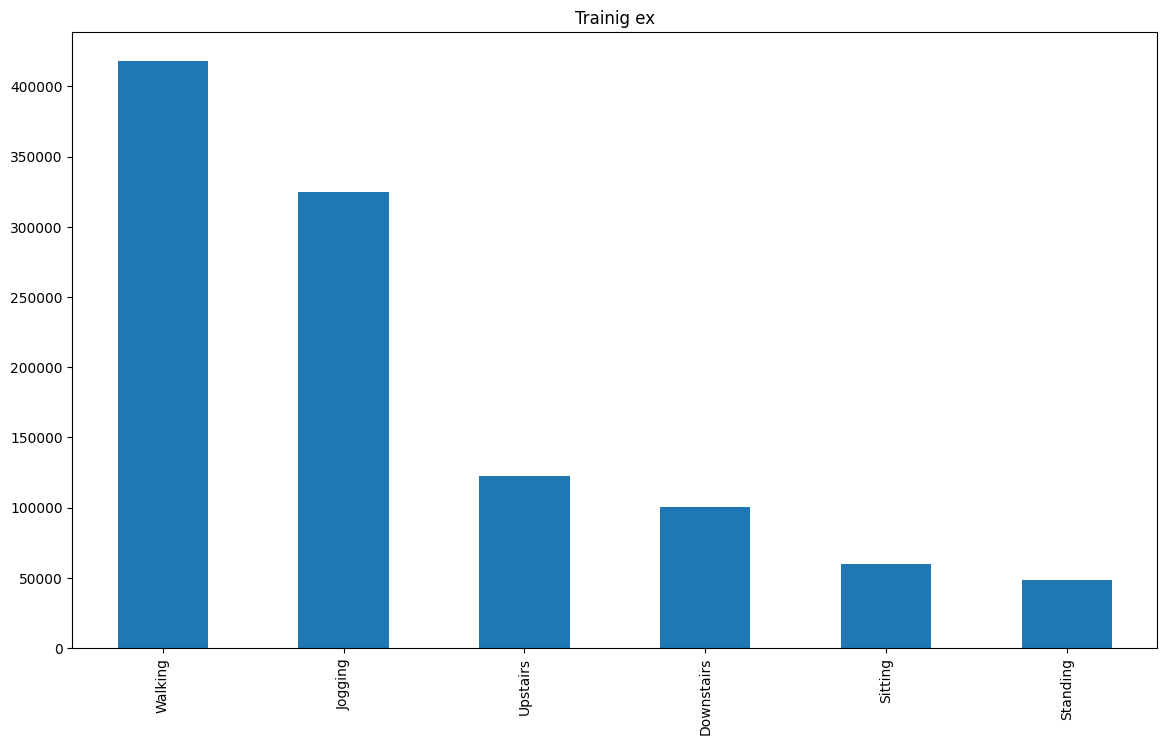

In [ ]:
countOfActivity.plot(kind='bar', title= 'Trainig ex', figsize=(14,8))

### No of samples belong to each volunteer

In [ ]:
countOfActivityPerPerson = df['user'].value_counts()
print(countOfActivityPerPerson)
totalActivity = countOfActivityPerPerson.sum()
print('total' + str(totalActivity))

20    54294
19    45382
31    44282
8     41187
14    38192
29    36768
13    36063
34    35947
3     35158
10    34875
27    33456
32    33357
12    32641
26    32578
36    32108
18    31705
11    31658
7     30967
1     29978
33    29453
6     28703
5     28509
15    26082
24    25736
23    25673
30    25334
21    23703
2     23525
35    22394
22    22308
17    22020
28    21358
16    20469
25    13468
9     12923
4     11369
Name: user, dtype: int64
total1073623


<Axes: title={'center': 'by user'}>

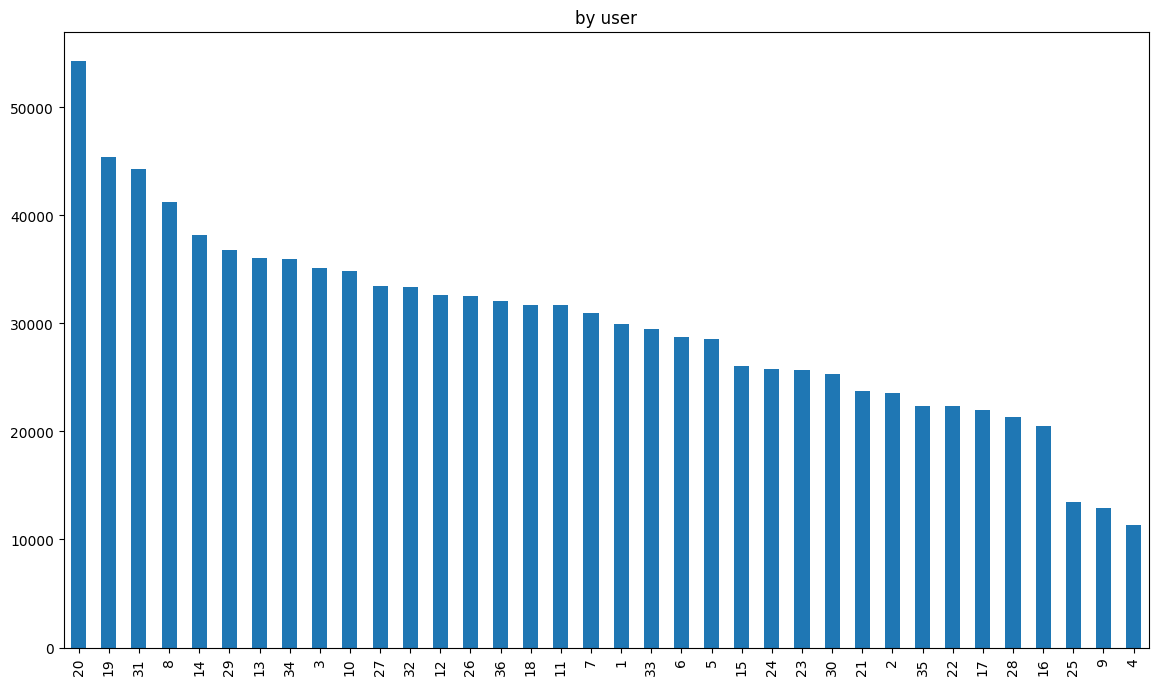

In [ ]:
countOfActivityPerPerson.plot(kind='bar', title='by user', figsize=(14,8))

### Data Preprocessing

In [ ]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])
    label = label[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

<ipython-input-31-10532c51bd88>:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['activity'][i: i + N_TIME_STEPS])
<ipython-input-31-10532c51bd88>:10: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  label = stats.mode(df['activity'][i: i + N_TIME_STEPS])


In [ ]:
np.array(segments).shape

(53672, 3, 200)

### Transforming shape of segments

In [ ]:
reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
reshaped_segments.shape

(53672, 200, 3)

### One hot encoding of labels

In [ ]:
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
print(labels)
print(labels.shape)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]
(53672, 6)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=100)

In [ ]:
print(X_train.shape, y_train.shape)

(42937, 200, 3) (42937, 6)


### Building the model

In [ ]:
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.models import Sequential

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(200, 3)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer="Adam", metrics=['accuracy'], loss='categorical_crossentropy')

In [ ]:
model.fit(X_train, y_train, epochs=16, batch_size=32, validation_data=(X_test, y_test))
model.save("model.hdf5")


Epoch 1/16
1342/1342 [==============================] - 53s 32ms/step - loss: 0.7569 - accuracy: 0.7335 - val_loss: 0.5538 - val_accuracy: 0.8024
Epoch 2/16
1342/1342 [==============================] - 50s 37ms/step - loss: 0.5027 - accuracy: 0.8138 - val_loss: 1.0881 - val_accuracy: 0.6459
Epoch 3/16
1342/1342 [==============================] - 41s 31ms/step - loss: 0.4052 - accuracy: 0.8415 - val_loss: 0.3153 - val_accuracy: 0.8759
Epoch 4/16
1342/1342 [==============================] - 44s 33ms/step - loss: 0.3033 - accuracy: 0.8820 - val_loss: 0.2844 - val_accuracy: 0.8904
Epoch 5/16
1342/1342 [==============================] - 42s 31ms/step - loss: 0.2699 - accuracy: 0.8972 - val_loss: 0.2278 - val_accuracy: 0.9095
Epoch 6/16
1342/1342 [==============================] - 42s 31ms/step - loss: 0.2308 - accuracy: 0.9138 - val_loss: 0.1949 - val_accuracy: 0.9273
Epoch 7/16
1342/1342 [==============================] - 42s 31ms/step - loss: 0.1924 - accuracy: 0.9303 - val_loss: 0.1668 -

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print(score)

[0.09569194912910461, 0.9659990668296814]
